In [1]:
import numpy as np
import pandas as pd
import cv2
import random
import csv
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
%matplotlib inline

In [20]:
from model import get_model
from generator import generator, get_image

In [3]:
base_path = '../../datasets/german_traffic_signs/'
train_path = base_path + 'imgs/train'
test_path = base_path + 'imgs/test'

In [4]:
imgpaths = [os.path.join(root, f).replace('\\', '/')
            for root, _, files in os.walk(train_path) 
            for f in files if f.endswith('.ppm')]
random.shuffle(imgpaths)

In [5]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(imgpaths, test_size=0.1, random_state=42)

n_train, n_valid = len(train), len(valid)
n_classes = len(list(open(base_path + 'signnames.csv'))) - 1

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of classes =", n_classes)

Number of training examples = 35288
Number of validation examples = 3921
Number of classes = 43


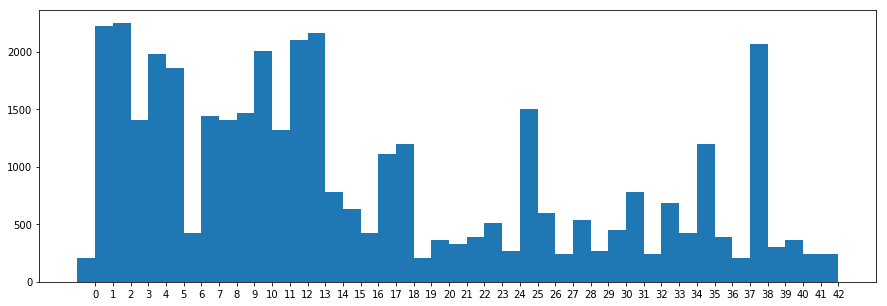

In [6]:
cls_counter = Counter()
y_train = []
for path in imgpaths:
    cls = int(path.split('/')[-2])
    y_train.append(cls)
    cls_counter[cls] += 1
    
labels, values = cls_counter.keys(), cls_counter.values()
indexes = np.arange(len(labels))

plt.figure(figsize=(15,5))
plt.bar(indexes, values, width=1)
plt.xticks(indexes + 0.5, labels)
plt.show()

In [7]:
class_weights = compute_class_weight('balanced', indexes, y_train)
cw_dict = dict(zip(indexes, class_weights))
cw_dict

{0: 4.3420819490586933,
 1: 0.41073748166771423,
 2: 0.40526098191214471,
 3: 0.64669305624278406,
 4: 0.46052384308198263,
 5: 0.49023505876469115,
 6: 2.1710409745293466,
 7: 0.63322028423772614,
 8: 0.64669305624278406,
 9: 0.62029742129409904,
 10: 0.45365035288672917,
 11: 0.69078576462297392,
 12: 0.43420819490586932,
 13: 0.42214685615848407,
 14: 1.1690220632081096,
 15: 1.447360649686231,
 16: 2.1710409745293466,
 17: 0.82147496333542847,
 18: 0.75986434108527134,
 19: 4.3420819490586933,
 20: 2.5328811369509046,
 21: 2.7631430584918957,
 22: 2.3380441264162193,
 23: 1.7879160966712266,
 24: 3.3771748492678726,
 25: 0.6078914728682171,
 26: 1.5197286821705427,
 27: 3.7993217054263564,
 28: 1.6885874246339363,
 29: 3.3771748492678726,
 30: 2.0263049095607237,
 31: 1.1690220632081096,
 32: 3.7993217054263564,
 33: 1.3234212036318223,
 34: 2.1710409745293466,
 35: 0.75986434108527134,
 36: 2.3380441264162193,
 37: 4.3420819490586933,
 38: 0.44050106729580946,
 39: 3.0394573643410

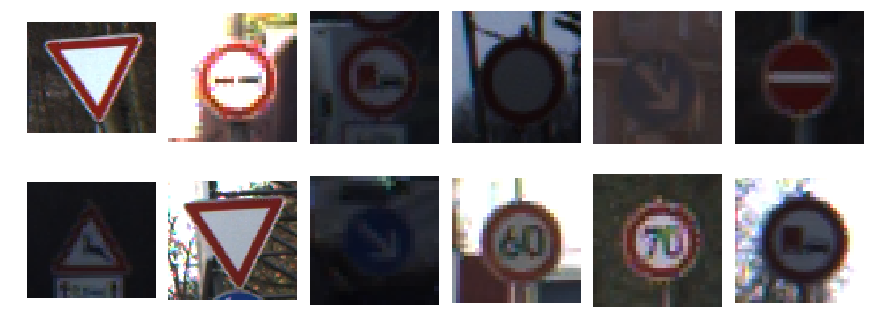

In [8]:
gs = gridspec.GridSpec(2, 6)
gs.update(wspace=0.1, hspace=0)
plt.figure(figsize=(15, 6))

sample = np.random.choice(imgpaths, size=12)
for i, path in enumerate(sample):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    ax = plt.subplot(gs[i])
    ax.set_aspect('equal')    
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

In [9]:
train_gen = generator(train, n_classes=n_classes, batch_size=16, augment=False)
valid_gen = generator(valid, n_classes=n_classes, batch_size=16)

In [10]:
model = get_model((32, 32, 3), n_classes=n_classes)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   1216        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

## Train and validate model

In [11]:
from keras.callbacks import ModelCheckpoint

model.fit_generator(generator=train_gen,
    validation_data=valid_gen,
    steps_per_epoch=1000,
    validation_steps=200,
    epochs=100,
    verbose=1,
    class_weight=cw_dict,
    callbacks=[
        ModelCheckpoint('weights/tsrnet.hdf5', verbose=1, monitor='val_loss', save_best_only=True)
    ])

Epoch 1/100
1000/1000 [==============================] - 175s 175ms/step - loss: 3.0300 - acc: 0.1659 - val_loss: 2.4411 - val_acc: 0.2619
Epoch 2/100
1000/1000 [==============================] - 157s 157ms/step - loss: 1.9014 - acc: 0.3823 - val_loss: 1.5142 - val_acc: 0.4938
Epoch 3/100
1000/1000 [==============================] - 157s 157ms/step - loss: 1.2352 - acc: 0.5637 - val_loss: 1.2714 - val_acc: 0.6144
Epoch 4/100
1000/1000 [==============================] - 158s 158ms/step - loss: 0.7080 - acc: 0.7348 - val_loss: 0.5132 - val_acc: 0.8272
Epoch 5/100
1000/1000 [==============================] - 159s 159ms/step - loss: 0.4409 - acc: 0.8269 - val_loss: 0.4786 - val_acc: 0.8581
Epoch 6/100
1000/1000 [==============================] - 159s 159ms/step - loss: 0.3394 - acc: 0.8723 - val_loss: 0.9778 - val_acc: 0.7406
Epoch 7/100
1000/1000 [==============================] - 158s 158ms/step - loss: 0.2323 - acc: 0.9065 - val_loss: 0.6224 - val_acc: 0.8078
Epoch 8/100
1000/1000 [====

1000/1000 [==============================] - 156s 156ms/step - loss: 0.0436 - acc: 0.9845 - val_loss: 0.0856 - val_acc: 0.9756
Epoch 31/100
1000/1000 [==============================] - 156s 156ms/step - loss: 0.0212 - acc: 0.9911 - val_loss: 0.0320 - val_acc: 0.9903
Epoch 32/100
1000/1000 [==============================] - 156s 156ms/step - loss: 0.0355 - acc: 0.9874 - val_loss: 0.1834 - val_acc: 0.9506
Epoch 33/100
1000/1000 [==============================] - 156s 156ms/step - loss: 0.0391 - acc: 0.9866 - val_loss: 0.1951 - val_acc: 0.9528
Epoch 34/100
1000/1000 [==============================] - 156s 156ms/step - loss: 0.0334 - acc: 0.9880 - val_loss: 0.3507 - val_acc: 0.9263
Epoch 35/100
1000/1000 [==============================] - 155s 155ms/step - loss: 0.0359 - acc: 0.9867 - val_loss: 0.0383 - val_acc: 0.9900
Epoch 36/100
1000/1000 [==============================] - 155s 155ms/step - loss: 0.0185 - acc: 0.9925 - val_loss: 0.0186 - val_acc: 0.9953
Epoch 37/100
1000/1000 [=========

KeyboardInterrupt: 

## Evaluate model on images from web

In [21]:
test_paths = [os.path.join(root, f).replace('\\', '/') 
              for root, _, files in os.walk(base_path + 'imgs/web') 
              for f in files if f.endswith('.png')]
images = []
for path in test_paths:
    images.append(get_image(path, augment=False))
len(images)

5

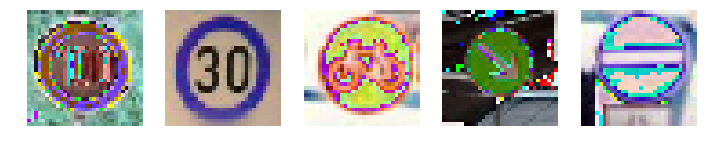

In [22]:
gs = gridspec.GridSpec(1, 5)
gs.update(wspace=0.01, hspace=0.02)
plt.figure(figsize=(12, 4))

for i, image in enumerate(images):
    ax = plt.subplot(gs[i])
    ax.set_aspect('equal')    
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')    

plt.show()

In [32]:
model.predict(np.expand_dims(images[3], axis=0))

array([[  6.70121778e-17,   3.07682178e-12,   1.69389554e-15,
          4.37828386e-17,   2.22897312e-10,   1.69681796e-16,
          1.00846022e-19,   4.42364380e-14,   8.95339247e-10,
          1.19611640e-17,   6.85821939e-18,   2.16267642e-16,
          2.37303586e-15,   1.02962376e-12,   1.30472030e-20,
          4.71133954e-23,   2.16953965e-19,   9.74716547e-17,
          1.07606198e-13,   8.13920632e-12,   1.94410456e-17,
          2.42249603e-18,   1.26381630e-20,   2.49132480e-16,
          5.62509575e-22,   1.85296299e-17,   7.93668008e-15,
          4.93580053e-24,   4.77789195e-22,   7.67562943e-25,
          9.69415611e-21,   4.89475525e-17,   9.58034382e-20,
          2.90083059e-18,   4.23776330e-13,   7.38538879e-16,
          7.60791811e-16,   1.08830969e-14,   1.00000000e+00,
          7.92651500e-11,   1.83799559e-10,   4.82832437e-18,
          1.56988798e-22]], dtype=float32)